# 1. Introduction

Let's assume that you have a marketing campaign for which we spend 1000USD for acquiring one potential customer. For each customer that we target with our ad campaign and that clicks on the ad, we get an overall profit of 100USD. However, if we target a customer that ends up not clicking on the ad, we incur a net loss of 1000USD. Therefore, we can conclude that for each customer that was not targeted by the campaign and who clicks on the ad, we get an overall profit of 1100USD. How would you approach this problem?


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline 


# 2. Data Exploration

We will first import the data and take a first look. We will also try to identify and address obvious issues with the data, such as missing values, duplicates, etc.

In [2]:
# Loading data
data = pd.read_csv('advertising_dsdj.csv')

In [3]:
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 0:53,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 1:39,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 2:31,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 3:36,0.0


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1018 entries, 0 to 1017
Data columns (total 10 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Daily Time Spent on Site  1018 non-null   float64
 1   Age                       1018 non-null   int64  
 2   Area Income               1018 non-null   float64
 3   Daily Internet Usage      1018 non-null   float64
 4   Ad Topic Line             1018 non-null   object 
 5   City                      1018 non-null   object 
 6   Male                      1018 non-null   int64  
 7   Country                   1018 non-null   object 
 8   Timestamp                 1018 non-null   object 
 9   Clicked on Ad             1014 non-null   float64
dtypes: float64(4), int64(2), object(4)
memory usage: 79.7+ KB


In [5]:
# Checking for missing values
data.isna().sum() 

Daily Time Spent on Site    0
Age                         0
Area Income                 0
Daily Internet Usage        0
Ad Topic Line               0
City                        0
Male                        0
Country                     0
Timestamp                   0
Clicked on Ad               4
dtype: int64

There seem to be 4 missing values in the target variable so we will drop these observations.

In [6]:
data = data.dropna(axis = 0)

In [7]:
# Checking for duplicates
print("Number of duplicated records in dataset:", data.duplicated().sum())

Number of duplicated records in dataset: 7


We drop the duplicated records.

In [8]:
data = data.drop_duplicates()

# 3. Exploratory data analysis

## 3.1 Describing the features and data cleaning

First, let's inspect the target variable for class imbalance.

In [9]:
# inspect for class imbalance of the target variable
data["Clicked on Ad"].value_counts() / data.shape[0]

1.0    0.502483
0.0    0.497517
Name: Clicked on Ad, dtype: float64

This is very well balanced classification problem. Therefore, we don't have to worry about class imbalance issues.

Let us separate numerical and categorical variables to take a quick look at the summary statistics.

In [10]:
def num_cat_columns(df):
    '''
    Separates numerical and categorical (type object) variables in given dataframe.
    Returns a 2 element list containing the list of numerical variable names as first 
    element and the list of categorical variable names as second element.
    This is a preliminary separation based on data type upon import and should be used
    with caution, as some int64 variables may be randomly generated IDs and not true 
    numerical variables and some categorical variables might be represented as numerical
    (e.g. classes).
    '''
    col_num = []
    col_cat = []
    for column in df.columns:
        if df[str(column)].dtypes != 'O':       
            col_num.append(column)
        else:
            col_cat.append(column)
    return [col_num, col_cat]

[col_num, col_cat] = num_cat_columns(data)

In [11]:
data[col_num].describe()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad
count,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000,1007.000000
mean,64.952403,36.958292,54899.398868,179.386514,0.482622,0.502483
std,15.850441,31.729539,13458.555374,44.548765,0.499946,0.500242
min,32.600000,-25.000000,13996.500000,23.640000,0.000000,0.000000
25%,51.270000,29.000000,46899.780000,138.490000,0.000000,0.000000
50%,68.100000,35.000000,56984.090000,182.200000,0.000000,1.000000
75%,78.535000,42.000000,65350.775000,218.550000,1.000000,1.000000
max,91.430000,999.000000,79484.800000,269.960000,1.000000,1.000000


In [12]:
data[col_cat].describe()

,Ad Topic Line,City,Country,Timestamp
count,1007,1007,1007,1007
unique,1000,969,237,997
top,Fundamental zero tolerance solution,Williamsport,Czech Republic,2016-07-06 3:40
freq,2,4,9,2


We see that for most of the true numerical features (not the classes 'Male' and 'Clicked on Ad'), the mean and the median are relatively close, indicating low skewness. This suggests that we are not likely to have to transform the data based on skewness when engineering features. We can confirm this later after visualisations.

However, we see that there are some bizarre values for the age feature: the minimum is negative and the maximum corresponds to an unrealistic human age. Let's visualise the Age feature by sorting it and plotting it against its index to easily see the outliers.

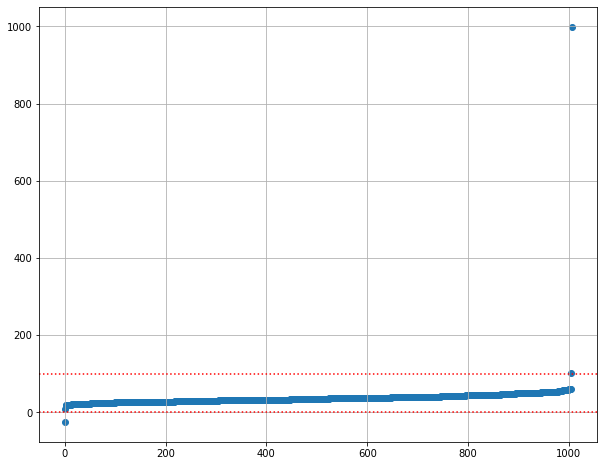

In [13]:
sorted_age = sorted(data['Age'])
indices = []
for i in range(len(sorted_age)):
    indices.append(i)
x = indices
y = sorted_age

plt.figure(figsize=(10,8))
plt.scatter(x, y)
plt.axhline(y=0, linestyle='dotted', color='r')
plt.axhline(y=100, linestyle='dotted', color='r')
plt.grid()


Let's take a closer look at the observations we have for extreme age values.

In [14]:
data[(data['Age'] < 18) | (data['Age'] > 80) ]

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
294,56.01,-25,46339.25,127.26,Re-engineered real-time success,Garciamouth,0,Tonga,2016-07-05 18:59,1.0
495,50.60,999,34191.13,129.88,Realigned reciprocal framework,New Daniellefort,1,United States of America,2016-05-03 12:57,1.0
604,57.20,103,57739.03,110.66,Innovative maximized groupware,East Heatherside,0,New Zealand,2016-03-19 11:09,1.0
823,43.16,8,25371.52,156.11,Implemented didactic support,Williamsport,1,Marshall Islands,2016-07-06 3:40,1.0


We can drop these observations as they are either obviously wrong or very likely to be included in the dataset due to error.

In [15]:
data = data[(data['Age'] >= 18) & (data['Age'] <= 80) ]

We will transfrom the Timestamp feature to datetime to be able to work with it.

In [16]:
data["Timestamp"] = pd.to_datetime(data["Timestamp"])

In [17]:
data.head()

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
0,68.95,35,61833.90,256.09,Cloned 5thgeneration orchestration,Wrightburgh,0,Tunisia,2016-03-27 00:53:00,0.0
1,80.23,31,68441.85,193.77,Monitored national standardization,West Jodi,1,Nauru,2016-04-04 01:39:00,0.0
2,69.47,26,59785.94,236.50,Organic bottom-line service-desk,Davidton,0,San Marino,2016-03-13 20:35:00,0.0
3,74.15,29,54806.18,245.89,Triple-buffered reciprocal time-frame,West Terrifurt,1,Italy,2016-01-10 02:31:00,0.0
4,68.37,35,73889.99,225.58,Robust logistical utilization,South Manuel,0,Iceland,2016-06-03 03:36:00,0.0


Let's also confirm that the time spent on site is less than the daily internet usage for all observations.

In [18]:
data[(data['Daily Internet Usage'] - data['Daily Time Spent on Site'] < 0)]

,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Ad Topic Line,City,Male,Country,Timestamp,Clicked on Ad
114,46.13,46,37838.72,23.64,Horizontal hybrid challenge,New Rachel,1,Guyana,2016-01-09 05:44:00,1.0
331,86.78,30,54952.42,70.13,Fundamental zero tolerance solution,New Steve,1,United States of America,2016-02-18 23:08:00,0.0
404,66.99,47,27262.51,24.44,Operative actuating installation,Lopezberg,1,Tanzania,2016-06-15 11:56:00,1.0


We finally remove these observations too.

In [19]:
data = data[~(data['Daily Internet Usage'] - data['Daily Time Spent on Site'] < 0)]